In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.signal
import scipy.ndimage
import scipy.sparse
import os
# helpers.py is one level up in the directory structure so we need to tell Python were to find it
import sys
sys.path.append("../../")
import helpers

# Gradient Based Image Blending
In this notebook you will implement gradient based image blending, which was originaly was described in the paper [Poisson Image Editing]( https://www.cs.virginia.edu/~connelly/class/2014/comp_photo/proj2/poisson.pdf). The goal of gradient based image blending is to copy a region of one image (source image) into another image (target image) without creating visible seams at the edge of the region.

**NOTE** In this exercise, we implement a version of the gradient based image blending scheme that is a bit simpler than what was discussed in the lecture. The difference is that we do not need to distinguish between inner and boundary gradients but only need one gradient matrix for the region to be filled.

As was covered in the lecture, the idea behind gradient based image blending is to find new pixel values such that the gradients of the source image are retained while making sure that there is no visible seam at the boundary of the avected region. We will now define this more formally. Let $I$ denote the set of pixels of the region to be filled, $B$ the set of boundary pixels and $g_i$ and $\tilde{g_i}$ denote the output and source gradients within the region to be filled respectively.

$$
\begin{align}
& \underset{U}{\text{minimize}}
& & f(U) = \sum\limits_{i \in I} {\lvert g_i - \tilde{g_i} \rvert}^2 + \alpha \sum\limits_{i \in B} {\lvert U - \tilde{U_t} \rvert}^2
\end{align}
$$

We can rewrite $f(U)$ using only matrix operations. Let $S$ be the selector matrix which selects all pixels on the boundary, $U$ the vector containing the output pixel values (in the region to be filled), $\tilde{U_s}$ the source pixel values (in the region to be filled) and $\tilde{U_t}$ the target pixel values (in the region to be filled). Let $G$ be the gradient matrix for the region to be filled. With the the gradient defined as  $g=GU$ we can derive the following quadratic polynomial:

$$
f(U) = {\lvert GU - G\tilde{U_s} \rvert}^2 + \alpha {\lvert SU - S\tilde{U_t} \rvert}^2 \\
f(U) = (U^TG^T - \tilde{U_s}^TG^T) (GU-G\tilde{U_s}) + \alpha (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) = U^T(G^TG)U - 2U^T(G^TG\tilde{U_s}) + \tilde{U_s}^TG^TG\tilde{U_s} + \alpha (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}S^TS\tilde{U_t}) \\
f(U) = U^T(G^TG + \alpha S^TS)U - 2U^T(G^TG\tilde{U_s} + \alpha S^TS\tilde{U_t}) + \tilde{U_s}^TG^TG\tilde{U_s} + \alpha \tilde{U_t}S^TS\tilde{U_t} \\
$$

We want to minimize the objective function and we know that at the minimum the derivative $f'(U)=0$. Using this knoweldge we can transform the problem into a linear system:

$$
f'(U) = 2(G^TG + \alpha S^TS)U - 2(G^TG\tilde{U_s} + \alpha S^TS\tilde{U_t}) = 0 \\
(G^TG + \alpha S^TS)U = G^TG\tilde{U_s} + \alpha S^TS\tilde{U_t} \\
%(L + \alpha S^TS)U = L\tilde{U_s} + \alpha S^TS\tilde{U_t}
$$

### Initialization
The following code loads the images that we will use for the image blending exercises.

C:\Users\Bas\AppData\Local\Temp/ipykernel_5660/582181427.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  swan_beach_mask = (swan_beach_mask > 0.5).astype(np.bool)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
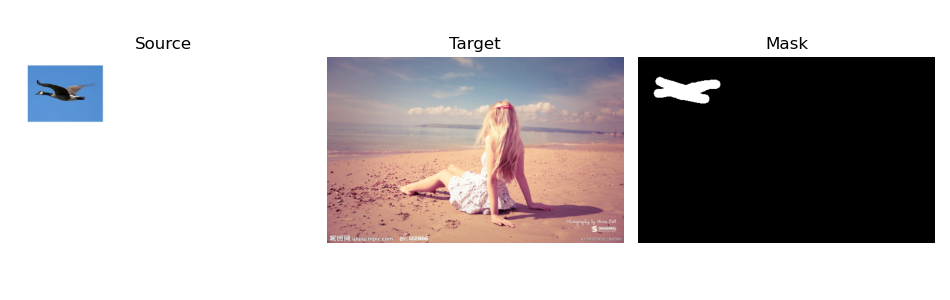

In [2]:
swan_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "swan.jpg"), 0.5)
beach_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "beach.jpg"), 0.5)
swan_beach_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "mask.jpg"), 0.5)
swan_beach_mask = (swan_beach_mask > 0.5).astype(np.bool)

helpers.show_images({ "Source": swan_image_color, "Target": beach_image_color,  "Mask": swan_beach_mask}, nrows=1, ncols=3)

## Exercise 3 (2 points)
Implement a function that returns the gradient matrix G. This matrix when multiplied by the (single color channel) image vector should result in a vector with all the gradients, both horizontal & vertical, between neighbouring pixels which are both **inside the mask** (pixels at which `mask[y,x] != 0`). We define the gradient between a pixel $U_i$ and neighbouring pixel $U_j$ as $\frac{1}{2} (U_j - U_i)$. Use `scipy.sparse.lil_matrix((num_rows, num_columns))` to construct a sparse matrix and convert it to `scipy.sparse.csr_matrix` before returning it. **Please refer to the image sharpening notebook on the order in which the gradients should appear**.

In [3]:
def construct_G(mask):
    
    height, width = mask.shape
    
    num_gradients = (width-1)*height + (height-1)*width
    num_pixels = width*height
    G = scipy.sparse.lil_matrix((num_gradients, num_pixels))
    next_empty = 0
    for i in range(height):
        for j in range(width-1):
            if mask[i,j] != 0 and mask[i,j+1] != 0:
                index = i * width + j
                G[next_empty, index] = -0.5
                G[next_empty, index+1] = 0.5
            next_empty += 1
            
    for i in range(height-1):
        for j in range(width):
            if mask[i,j] != 0 and mask[i+1,j] != 0:
                index = i * width + j
                G[next_empty, index] = -0.5
                G[next_empty, index+width] = 0.5
            next_empty += 1
    
    # Convert scipy.sparse.lil_matrix to scipy.sparse.csr_matrix for efficient processing
    G = scipy.sparse.csr_matrix(G)
    G = G[G.getnnz(1)>0][:,G.getnnz(0)>0]
    return G

### Testing your solution of exercise 3
This code visualizes the gradients generated by your $G$ matrix. With `construct_G` implemented it should show the gradient magnitudes of the bird image. The cell below also has some very basic tests to make sure that the gradients 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
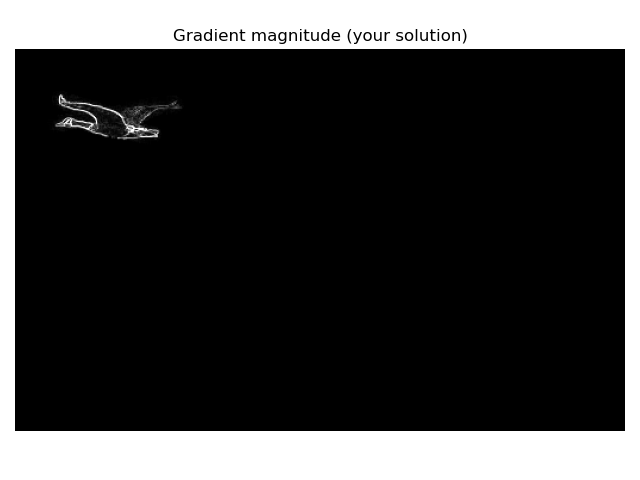

In [4]:
def construct_U(image, mask):
    indices = np.nonzero(mask)
    return image[indices].flatten()

# Convert a gradient vector for a given mask into an image visualizing the gradient magnitude
def gradient_to_image(g, mask):
    out_image = np.zeros(mask.shape)
    
    # gx**2 at each pixel
    i = 0
    for (y, x) in zip(*np.nonzero(mask)):
        if mask[y, x+1]:
            out_image[y, x] += g[i]**2
            i += 1
            
    # gy**2 at each pixel
    for (y, x) in zip(*np.nonzero(mask)):
        if mask[y+1, x]:
            out_image[y, x] += g[i]**2
            i += 1
    
    return np.sqrt(out_image)

green_channel = swan_image_color[:,:,1]
G = construct_G(swan_beach_mask)
u = construct_U(green_channel, swan_beach_mask)
g = G * u

gradient_image = gradient_to_image(g, swan_beach_mask)

# Increase contrast to make it easier to spot the gradients
gradient_image = np.clip(5 * gradient_image, 0, 1)

helpers.show_image(gradient_image, "Gradient magnitude (your solution)")

In [5]:
# Test on a simple 2x2 mask
dummy_mask = np.zeros((4,4))
for y in range(1, 3):
    for x in range(1, 3):
        dummy_mask[y, x] = 1
G = construct_G(dummy_mask)
assert(type(G) == scipy.sparse.csr_matrix)
G = G.toarray()
assert((G[0,:] == [-0.5, 0.5, 0, 0]).all())# gx between (1,1) and (2,1)
assert((G[2,:] == [-0.5, 0, 0.5, 0]).all())# gy between (1,1) and (1,2)

## Exercise 4 (2 points)
Now implement a function that returns the selector matrix $S$. The selector matrix selects only those pixels from the mask that lie on the boundary. Hence, the number of rows should match the number of boundary pixels and the number of columns should match the number of pixels inside the mask. A pixel is inside the mask if `mask[x,y] != 0`. Each row should have exactly one entry (set to $1.0$) which corresponds to the next boundary pixel.

A pixel (inside the mask) is on the boundary if any of it's 4-connected (left, top, right, bottom) neighbours is outside the mask. Again, make sure to construct $S$ as a `scipy.sparse.lil_matrix` matrix and convert it to a `scipy.sparse.csr_matrix` before returning.


**WARNING**: the grading script requires the entries of $S$ to be ordered in a specific way. Make sure that the boundary pixels are selected from left to right, and top to bottom.

In [6]:
def construct_S(mask):
    rows, cols = mask.shape
    num_pixels = (mask > 0).sum()
    
    S = []
     
    index = 0
    for row in range(rows):
        for col in range(cols):
            if mask[row,col] !=0:
                if mask[row+1,col] == 0 or mask[row,col+1] == 0 \
                or mask[row-1,col] == 0 or mask[row,col-1] == 0:
                    li = list(np.zeros(num_pixels))
                    li[index] = 1
                    if li not in S:
                        S.append(li)
                index += 1
    
    return scipy.sparse.csr_matrix(S)

### Testing your solution of exercise 4
The matrix S should select the boundary pixels from the vector of masked pixels. We provide a basic test to check if the matrix you returned has the correct size.

In [7]:
# Check if matrix has the correct size
S = construct_S(swan_beach_mask)
assert(type(S) == scipy.sparse.csr_matrix)
assert(S.shape == (316, 3118))

mask = np.array([
    [0, 0, 1, 0], # [-, -, 0, -]
    [0, 1, 1, 1], # [-, 1, 2, 3]
    [0, 1, 1, 0], # [-, 4, 5, -]
    [0, 0, 0, 0] #  [-, -, -, -]
])
S = construct_S(mask)
assert(S[0, 0] == 1.0)
assert(S[1, 1] == 1.0)
assert(S[2, 3] == 1.0)
assert(S[3, 4] == 1.0)
assert(S[4, 5] == 1.0)


## Exercise 5 (2 points)
We now have all the matrices required to formulate the linear system. To operate on color images, seamless cloning can be applied to each color channel individually. Implement a function that performs a seamless clone on a single color channel by solving the linear system described above (using `scipy.sparse.linalg.solve`). The inputs of this function are a single color channel of the source, target and mask images (all with the same shape), the gradient matrix $G$, the selector matrix $S$ and $\alpha$ to indicate the strength of the soft constraint. The function should return the final result of that color channel (as a 2D numpy array).

[[0.41960785 0.42352942 0.43137255 ... 0.28235295 0.27843139 0.27450982]
 [0.43529412 0.42352942 0.42745098 ... 0.28627452 0.28235295 0.28235295]
 [0.43137255 0.43137255 0.43529412 ... 0.29019609 0.29019609 0.28235295]
 ...
 [0.51372552 0.60392159 0.57647061 ... 0.61176473 0.61176473 0.61960787]
 [0.56862748 0.58039218 0.59215689 ... 0.61176473 0.61960787 0.61176473]
 [0.49411765 0.45882353 0.45490196 ... 0.61176473 0.6156863  0.62352943]]
[[0.38039216 0.38431373 0.39215687 ... 0.30980393 0.30588236 0.3019608 ]
 [0.39607844 0.38431373 0.3882353  ... 0.31764707 0.3137255  0.30980393]
 [0.39215687 0.3882353  0.39215687 ... 0.32156864 0.32156864 0.3137255 ]
 ...
 [0.26666668 0.35686275 0.32941177 ... 0.36862746 0.36862746 0.3764706 ]
 [0.32156864 0.33333334 0.34509805 ... 0.36862746 0.3764706  0.36862746]
 [0.24313726 0.20784314 0.20784314 ... 0.36470589 0.37254903 0.38039216]]
[[0.51764709 0.52156866 0.52941179 ... 0.50980395 0.50980395 0.50588238]
 [0.53333336 0.52156866 0.52549022 ... 

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
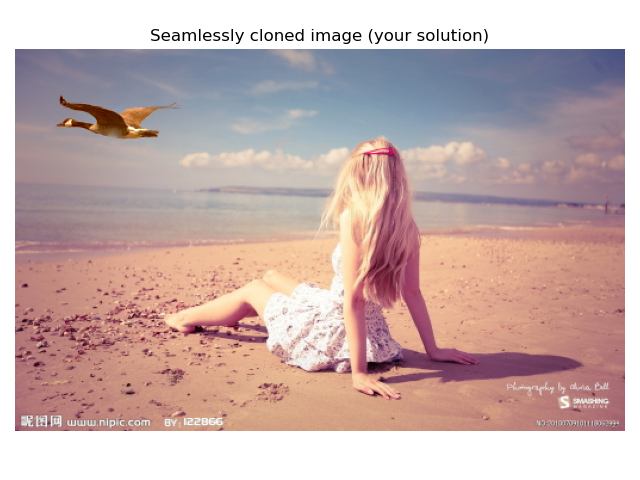

In [22]:
def seamless_clone_channel(source, target, mask, G, S, alpha):
    A = G.T @ G + alpha * S.T @ S
    Us = construct_U(source, mask)
    Ut = construct_U(target, mask)
    b = G.T @ G @ Us + alpha * S.T @ S @ Ut
    U = scipy.sparse.linalg.spsolve(A, b)
    
    h, w = target.shape
    new = np.zeros((h,w))
    index = 0
    
    for i in range(h):
        for j in range(w):
            if mask[i,j] == 0:
                new[i,j] = target[i,j]
            else:
                new[i,j] = U[index]
                index += 1
    print(new)
    return new

def seamless_clone(source_image, target_image, mask, G, S, alpha):
    red_channel = seamless_clone_channel(source_image[:,:,0], target_image[:,:,0], mask, G, S, alpha)
    green_channel = seamless_clone_channel(source_image[:,:,1], target_image[:,:,1], mask, G, S, alpha)
    blue_channel = seamless_clone_channel(source_image[:,:,2], target_image[:,:,2], mask, G, S, alpha)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

G = scipy.sparse.load_npz(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "swan_beach_reference_G.npz"))
S = scipy.sparse.load_npz(os.path.join(helpers.dataset_folder, "week2", "poisson", "swan_on_beach", "swan_beach_reference_S.npz"))

result_image = seamless_clone(swan_image_color, beach_image_color, swan_beach_mask, G, S, 0.5)
result_image = np.clip(result_image, 0, 1)

helpers.show_image(result_image, "Seamlessly cloned image (your solution)")

### Testing your solution of exercise 5
After implementing exercise 5 the image above should show the girl on the beach with the bird filled in. The bird will appear yellow-ish to match the tone of the environment.

# Mixed Gradients (NOT GRADED)
**The exercises below do not count for points and are completely optional. Only do these exercises if you have finished the graded ones.**

The result of our seamless cloning looks convincing when the masked region of the target image does not contain a lot of detail, like in the example images that we used above. However, when we apply our technique to a highly textured target image then the resulting image will look blurry. This happens because we completely ignore the targets gradients, replacing them by the source gradient. If the source gradients are low (it has a smooth background) than the linear system will smoothly interpolate between the boundaries, resulting in a blurry mess.

In [10]:
drawing_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "drawing.jpg"), 0.5)
sign_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "sign.png"), 0.5)
drawing_sign_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mask.jpg"), 0.5)
drawing_sign_mask = (drawing_sign_mask > 0.5).astype(bool)

G = construct_G(drawing_sign_mask)
S = construct_S(drawing_sign_mask)
result_color = seamless_clone(drawing_image_color, sign_image_color, drawing_sign_mask, G, S, 0.5)
result_color = np.clip(result_color, 0, 1)
helpers.show_image(result_color, title="Result")

KeyboardInterrupt: 

If the source image has a flat background like in this example than we can improve the result by mixing the gradients of the source and target image. We modify the equation such that at each pixel the gradient (between the pixel and its left/bot neighbours) should match that of either the source or the target, whichever has the highest magnitude.

$$
f(U) = {\lvert GU - \tilde{V} \rvert}^2 + \alpha {\lvert SU - S\tilde{U_t} \rvert}^2 \\
f(U) = (U^TG^T - \tilde{V}^T) (GU-\tilde{V}) + \alpha (U^TS^T - \tilde{U_t}^TS^T)(SU - S\tilde{U_t}) \\
f(U) = U^T(G^TG)U - 2U^T(G^T\tilde{V}) + \tilde{V}^T\tilde{V} + \alpha (U^TS^TSU - 2U^TS^TS\tilde{U_t} + \tilde{U_t}S^TS\tilde{U_t}) \\
f(U) = U^T(G^TG + \alpha S^TS)U - 2U^T(G^T\tilde{V} + \alpha S^TS\tilde{U_t}) + \tilde{V}^T\tilde{V} + \alpha \tilde{U_t}S^TS\tilde{U_t} \\
$$

Here $\tilde{V}$ is the gradient vector containing $max(\tilde{g_{source}}, \tilde{g_{target}})$. We want to minimize the objective function so we need to find where the derivative is zero:

$$
f'(U) = 2(G^TG + \alpha S^TS)U - 2(G^T\tilde{V} + \alpha S^TS\tilde{U_t}) = 0 \\
(G^TG + \alpha S^TS)U = G^T\tilde{V} + \alpha S^TS\tilde{U_t} \\
%(L + \alpha S^TS)U = G^T\tilde{V} + \alpha S^TS\tilde{U_t}
$$

## Exercise 6 (OPTIONAL)
Implement a function that computes the vector $V$ which contains the desired output gradients. For each pixel in the masked region compute the partial derivatives ($g_x$ and $g_y$) between it and its right/bottom neighbours for both the source and the target image. Store the partial derivatives from either the source or the target image based on whichever has the highest gradient magnitude ($\lvert{g}\rvert=\sqrt{g_x^2+g_y^2}$). Do not store a partial derivative if the associated neighbour is not in the mask. You are free to ignore the edge case of the masked region containing pixels on the boundary of the image.

In [ ]:
def construct_V(source, target, mask):
    # YOUR CODE HERE
    raise NotImplementedError()

### Testing your solution of exercise 6
This first code cell shows a visaulization of the gradient magnitude, comparing it to the reference. The second cell contains the actual tests.

In [ ]:
source_g = drawing_image_color[:,:,1]
target_g = sign_image_color[:,:,1]

V = construct_V(source_g, target_g, drawing_sign_mask)

gradient_image = gradient_to_image(V, drawing_sign_mask)

# Increase contrast
gradient_image = np.clip(5 * gradient_image, 0, 1) 
gradient_image_reference = np.clip(5 * gradient_image_reference, 0, 1)

helpers.show_images({ "Gradient magnitude (your solution)": gradient_image, "Gradient magnitude (reference)": gradient_image_reference }, nrows=1, ncols=2)

In [ ]:
drawing_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "drawing.jpg"), 0.5)
sign_image_color = helpers.imread_normalized_float(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "sign.png"), 0.5)
drawing_sign_mask = helpers.imread_normalized_float_grayscale(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mask.jpg"), 0.5)

# === COLOR CHANNEL 0 (RED) ===
source_r = drawing_image_color[:,:,0]
target_r = sign_image_color[:,:,0]
V = construct_V(source_r, target_r, drawing_sign_mask)
gradient_image = gradient_to_image(V, drawing_sign_mask)
gradient_image_reference = np.load(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mixed_gradient_image0.npy"))
gradient_image = np.clip(gradient_image, 0, 1) 
gradient_image_reference = np.clip(gradient_image_reference, 0, 1)
first_correct = helpers.SSD_per_pixel(gradient_image, gradient_image_reference) < 0.0001

# === COLOR CHANNEL 1 (GREEN) ===
source_g = drawing_image_color[:,:,1]
target_g = sign_image_color[:,:,1]
V = construct_V(source_g, target_g, drawing_sign_mask)
gradient_image = gradient_to_image(V, drawing_sign_mask)
gradient_image_reference = np.load(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mixed_gradient_image1.npy"))
gradient_image = np.clip(gradient_image, 0, 1) 
gradient_image_reference = np.clip(gradient_image_reference, 0, 1)
second_correct = helpers.SSD_per_pixel(gradient_image, gradient_image_reference) < 0.0001

if first_correct and second_correct:
    print("Correct")
else:
    print("Incorrect")

## Exercise 7 (OPTIONAL)
Implement seamless cloning with mixed gradients using the formula given above. Like with the basic seamless cloning the process is applied to each color channel individually. Use `scipy.sparse.linalg.spsolve` to solve the linear system.

In [ ]:
def seamless_clone_mixed_gradient_color(source, target, mask, alpha):
    # YOUR CODE HERE
    raise NotImplementedError()

def seamless_clone_mixed_gradient(source_image, target_image, mask, alpha):
    mask = mask > 0.5
    red_channel = seamless_clone_mixed_gradient_color(source_image[:,:,0], target_image[:,:,0], mask, alpha)
    green_channel = seamless_clone_mixed_gradient_color(source_image[:,:,1], target_image[:,:,1], mask, alpha)
    blue_channel = seamless_clone_mixed_gradient_color(source_image[:,:,2], target_image[:,:,2], mask, alpha)
    return np.stack([red_channel, green_channel, blue_channel], axis=2)

result = seamless_clone_mixed_gradient(drawing_image_color, sign_image_color, drawing_sign_mask, 1)
result_reference = np.load(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mixed_reference.npy"))
result = np.clip(result, 0, 1)
result_reference = np.clip(result_reference, 0, 1)
helpers.show_images({"Your solution": result, "Reference": result_reference }, nrows=1, ncols=2)

### Testing your solution of exercise 7
If you implemented exercise 7 correctly then your sharpening filter should match the reference.

In [ ]:
# === DRAWING ON SIGN ===
result = seamless_clone_mixed_gradient(drawing_image_color, sign_image_color, drawing_sign_mask, 1)
reference = np.load(os.path.join(helpers.dataset_folder, "week2", "poisson", "drawing_on_sign", "mixed_reference.npy"))
assert(helpers.SSD_per_pixel(result, reference) < 0.0001)